<a href="https://colab.research.google.com/github/S-Asghari/Fact-Checking-Using-LLMs/blob/main/fine-tuning/BERT/BERT_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Libraries

In [1]:
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForPreTraining, BertForSequenceClassification, EncoderDecoderModel, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00


# 1. Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/DeClare/Snopes.tsv', sep='\t', header=None)
df.columns = ['label', 'claim_id', 'claim', 'text', 'article_source']
df.drop(['claim_id', 'article_source'], axis=1, inplace=True)

df.head()

,label,claim,text
0,True,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...
1,True,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...
2,True,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...
3,True,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...
4,True,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...


# 2. Tokenize input

In [4]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
df['input'] = df['claim'] + bert_tokenizer.sep_token + df['text']
# df['input'] = "Use the following text to discover the correctness of the claim at the end. Respond with either true or false." + bert_tokenizer.sep_token + df['text'] + bert_tokenizer.sep_token + df['claim']

25
127
107.80018466589152
108.0


<Axes: ylabel='Frequency'>

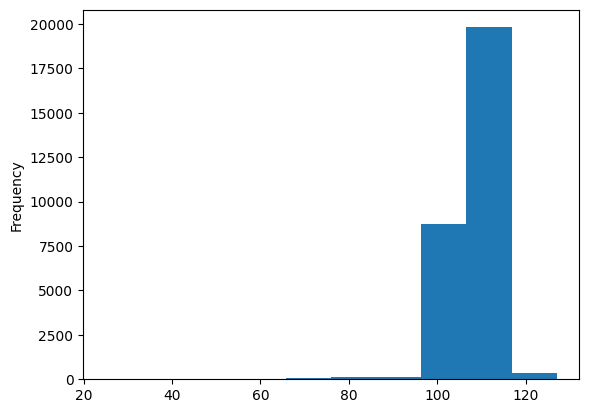

In [6]:
# lengths = df.input.apply(lambda x: len(x.split()))
# print(lengths.min())
# print(lengths.max())
# print(lengths.mean())
# print(lengths.median())
# lengths.plot.hist()

In [7]:
def bert_encoder(seq, tokenizer, max_length=128):   # For bert_set.csv, max_length is 512.
  encoding = tokenizer.encode(seq, max_length=max_length, padding="max_length", truncation=True)
  return encoding
df['input_tokens'] = df.input.apply(bert_encoder, tokenizer=bert_tokenizer)
# df.head()

In [8]:
df.to_csv('/content/drive/MyDrive/DeClare/input_encoded_base_128(snopes).csv', index=False)

# 3. Train and fine tune the model

In [9]:
df = pd.read_csv('/content/drive/MyDrive/DeClare/input_encoded_base_128(snopes).csv')

In [ ]:
# df['label'].replace({'true':True, 'false':False}, inplace=True)

In [10]:
df['input_tokens'] = df['input_tokens'].apply(eval)

In [11]:
input_tokens, label_tokens = df.input_tokens.to_list(), df.label.to_list()

In [12]:
train_input, val_test_input, train_label, val_test_label = train_test_split(input_tokens, label_tokens, test_size=0.2, random_state=42)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
train_input = torch.tensor(train_input).to(device)
train_label = torch.tensor(train_label).to(device)
val_input = torch.tensor(val_test_input).to(device)
val_label = torch.tensor(val_test_label).to(device)

In [15]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)
# model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
train_data = TensorDataset(train_input, train_label)
val_data = TensorDataset(val_input, val_label)

In [17]:
batch_size = 32   # 64 doesn't work for me :(
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [18]:
optimizer = AdamW(model.parameters(), lr=5e-5)  # Should I change the learning rate?

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
num_epochs = 3
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0
    for input_batch, label_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids=input_batch, labels=label_batch.float())
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for input_batch, label_batch in val_loader:
            outputs = model(input_ids=input_batch, labels=label_batch.float())
            loss = outputs.loss
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1: Train Loss = 0.0729, Val Loss = 0.0247
Epoch 2: Train Loss = 0.0116, Val Loss = 0.0230
Epoch 3: Train Loss = 0.0087, Val Loss = 0.0168


In [20]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DeClare/bert_model(snopes).pth')